# Cancer Stage Classification using 3D ResNet

This notebook implements a 3D ResNet model for lung cancer stage classification using CT scans.

In [10]:
# Standard imports
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pydicom  
from scipy import ndimage
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Import custom modules
from Data_understanding import (load_csv_labels, load_ct_scan_from_slices, load_and_stack_ct_slices, find_patient_data_paths)

# Import our CT preprocessing module
from ct_preprocessing import (preprocess_ct_scan, visualize_preprocessing, 
                             resample_volume, normalize_hu_values, resize_volume, 
                             center_crop_or_pad, enhance_contrast, apply_lung_window,
                             load_dicom_series_safely, preprocess_dicom_directory)

# Import our CT data augmentation module
from ct_augmentation import (augment_ct_scan, visualize_augmentation_effects, create_augmented_batch, visualize_augmentations,
                            random_rotation_3d, random_shift_3d, random_flip_3d, random_zoom_3d,
                            random_noise_3d, random_gamma_3d, random_contrast_3d, elastic_deformation_3d)

# Import modules from the train_3d_resnet.py file
from train_3d_resnet import (
    set_seed, BasicBlock3D, ResNet3D, ResNet18_3D, CTScanDataset,
    train_model, evaluate_model, plot_training_history, plot_confusion_matrix
)

# Import direct dataset
from direct_dataset import DirectCTScanDataset

## Set Configuration Parameters

In [12]:
# Configuration parameters
csv_path = "E:/cancer stage/lung_csv.csv"  # CSV file with patient IDs and cancer stage labels
patch_size = (64, 64, 64)  # Size of patches to extract from CT volumes
batch_size = 8  # Batch size for training
num_epochs = 30  # Maximum number of epochs
patience = 10  # Patience for early stopping
learning_rate = 0.001  # Initial learning rate
weight_decay = 1e-4  # Weight decay for regularization
model_save_path = "resnet18_3d_cancer_stage.pth"  # Path to save the trained model
base_dir = "E:/cancer stage/NSCLC-Radiomics" 
target_spacing = (1.0, 1.0, 1.0)  # Target voxel spacing in mm
target_shape = (128, 256, 256)  # Target shape for preprocessing
use_augmentation = True  # Whether to use augmentation for training
use_direct_processing = True  # Whether to use direct processing without saving to disk

# Set random seeds for reproducibility
set_seed(42)

## Directory Structure

The CT scan data is organized in a specific directory structure:

```
E:/cancer stage/NSCLC-Radiomics/
├── LUNG1-001/
│   └── 01-01-2014-StudyID-NA-12345/
│       ├── 1.000000-NA-54321/  # CT scan DICOM slices
│       │   ├── 000000.dcm
│       │   ├── 000001.dcm
│       │   └── ...
│       └── 300.000000-Segmentation-67890/  # Segmentation mask
│           └── 000000.dcm
├── LUNG1-002/
│   └── ...
└── ...
```

The `find_patient_data_paths` function in `Data_understanding.py` navigates this structure to find the CT scan and segmentation mask for each patient.

## Examine the CSV File Structure

In [13]:
# Load and examine the CSV file
df = pd.read_csv(csv_path)
print(f"CSV file has {len(df)} rows and {len(df.columns)} columns")
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst 5 rows:")
display(df.head())

# Check for NaN values in the cancer stage column
stage_column = 'Overall.Stage'
nan_count = df[stage_column].isna().sum()
print(f"\nNumber of NaN values in {stage_column}: {nan_count}")

# Check unique values in the cancer stage column
print(f"\nUnique values in {stage_column}:")
print(df[stage_column].unique())

CSV file has 422 rows and 10 columns

Column names:
['PatientID', 'age', 'clinical.T.Stage', 'Clinical.N.Stage', 'Clinical.M.Stage', 'Overall.Stage', 'Histology', 'gender', 'Survival.time', 'deadstatus.event']

First 5 rows:


,PatientID,age,clinical.T.Stage,Clinical.N.Stage,Clinical.M.Stage,Overall.Stage,Histology,gender,Survival.time,deadstatus.event
0,LUNG1-001,78.7515,2.0,3,0,IIIb,large cell,male,2165,1
1,LUNG1-002,83.8001,2.0,0,0,I,squamous cell carcinoma,male,155,1
2,LUNG1-003,68.1807,2.0,3,0,IIIb,large cell,male,256,1
3,LUNG1-004,70.8802,2.0,1,0,II,squamous cell carcinoma,male,141,1
4,LUNG1-005,80.4819,4.0,2,0,IIIb,squamous cell carcinoma,male,353,1



Number of NaN values in Overall.Stage: 1

Unique values in Overall.Stage:
['IIIb' 'I' 'II' 'IIIa' nan]


In [9]:
nan_percentage = (df['Overall.Stage'].isna().mean()) * 100
print(f"Percentage of NaN values in Overall.Stage: {nan_percentage:.2f}%")

Percentage of NaN values in Overall.Stage: 0.24%


Original class distribution:
Overall.Stage
IIIb    176
IIIa    112
I        93
II       40
Name: count, dtype: int64

Class distribution after merging IIIa and IIIb:
Overall.Stage
III    288
I       93
II      40
Name: count, dtype: int64


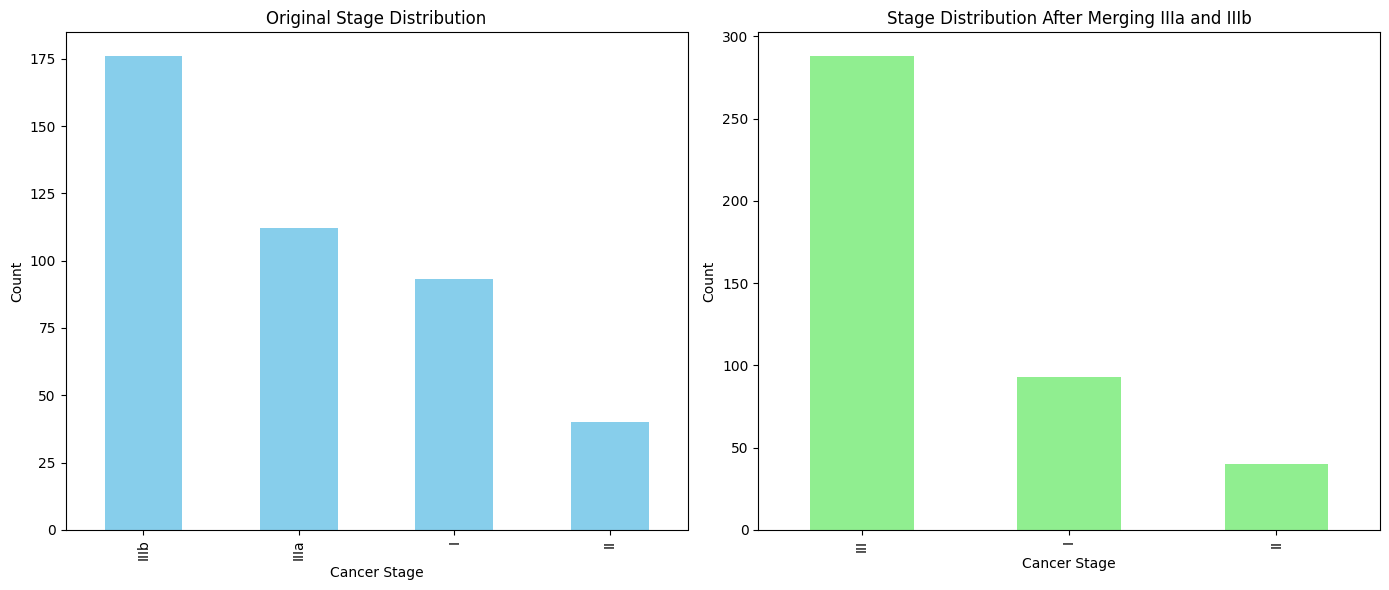


Computed class weights for training:
Stage III: 0.4873
Stage I: 1.5090
Stage II: 3.5083


In [14]:
# Analyze class distribution before and after merging IIIa and IIIb
import matplotlib.pyplot as plt

# Original distribution
print("Original class distribution:")
original_dist = df['Overall.Stage'].value_counts()
print(original_dist)

# Create a copy of the dataframe with merged stages
df_merged = df.copy()
df_merged['Overall.Stage'] = df_merged['Overall.Stage'].replace({'IIIa': 'III', 'IIIb': 'III'})

# Distribution after merging
print("\nClass distribution after merging IIIa and IIIb:")
merged_dist = df_merged['Overall.Stage'].value_counts()
print(merged_dist)

# Visualize both distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Original distribution
original_dist.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Original Stage Distribution')
ax1.set_ylabel('Count')
ax1.set_xlabel('Cancer Stage')

# Merged distribution
merged_dist.plot(kind='bar', ax=ax2, color='lightgreen')
ax2.set_title('Stage Distribution After Merging IIIa and IIIb')
ax2.set_ylabel('Count')
ax2.set_xlabel('Cancer Stage')

plt.tight_layout()
plt.show()

# Calculate class weights for the merged distribution
total_samples = len(df_merged.dropna(subset=['Overall.Stage']))
num_classes = len(merged_dist)
weights = total_samples / (merged_dist * num_classes)

print("\nComputed class weights for training:")
for stage, weight in weights.items():
    print(f"Stage {stage}: {weight:.4f}")

### Test the Directory Navigation

In [15]:
# Test the find_patient_data_paths function with a few patient IDs
test_patients = ['LUNG1-001', 'LUNG1-002', 'LUNG1-003']

for patient_id in test_patients:
    print(f"\nFinding data paths for patient {patient_id}...")
    ct_dir, mask_path = find_patient_data_paths(base_dir, patient_id)
    
    if ct_dir is not None:
        print(f"CT scan directory: {ct_dir}")
        # Count DICOM files in the CT directory
        ct_files = [f for f in os.listdir(ct_dir) if f.endswith('.dcm')]
        print(f"Number of CT DICOM files: {len(ct_files)}")
    else:
        print("CT scan directory not found")
    
    if mask_path is not None:
        print(f"Segmentation mask: {mask_path}")
    else:
        print("Segmentation mask not found")


Finding data paths for patient LUNG1-001...
No CT scan directory found for patient LUNG1-001
CT scan directory not found
Segmentation mask not found

Finding data paths for patient LUNG1-002...
CT scan directory: E:/cancer stage/NSCLC-Radiomics\LUNG1-002\01-01-2014-StudyID-NA-85095\1.000000-NA-61228
Number of CT DICOM files: 111
Segmentation mask: E:/cancer stage/NSCLC-Radiomics\LUNG1-002\01-01-2014-StudyID-NA-85095\300.000000-Segmentation-5.421\1-1.dcm

Finding data paths for patient LUNG1-003...
CT scan directory: E:/cancer stage/NSCLC-Radiomics\LUNG1-003\01-01-2014-StudyID-NA-34270\1.000000-NA-28595
Number of CT DICOM files: 107
Segmentation mask: E:/cancer stage/NSCLC-Radiomics\LUNG1-003\01-01-2014-StudyID-NA-34270\300.000000-Segmentation-2.316\1-1.dcm


### Handling Directory Structure Issues

If you encounter issues with the directory structure, here are some common problems and solutions:

1. **Different directory naming patterns**: The `find_patient_data_paths` function looks for directories with specific patterns:
   - Study directories containing 'StudyID' in the name
   - CT scan directories starting with '1.000000'
   - Segmentation mask directories starting with '300.000000'
   
   If your directory structure is different, you may need to modify the `find_patient_data_paths` function.

2. **Missing CT scan or mask**: The function will return `None` for the CT scan directory or mask path if they can't be found.

3. **Multiple study directories**: If a patient has multiple study directories, the function will use the first one it finds.

4. **Empty directories**: The function checks if directories exist but doesn't verify if they contain DICOM files. This is handled later in the data loading process.

## Create Datasets and DataLoaders

In [16]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create datasets and dataloaders
if use_direct_processing:
    print("\nUsing direct processing without saving to disk...")
    train_dataset = DirectCTScanDataset(
        base_dir=base_dir,
        csv_path=csv_path,
        patch_size=patch_size,
        target_spacing=target_spacing,
        target_shape=target_shape,
        mode='train',
        use_augmentation=use_augmentation,
        augmentation_types=None
    )
    
    val_dataset = DirectCTScanDataset(
        base_dir=base_dir,
        csv_path=csv_path,
        patch_size=patch_size,
        target_spacing=target_spacing,
        target_shape=target_shape,
        mode='val',
        use_augmentation=False
    )
    
    test_dataset = DirectCTScanDataset(
        base_dir=base_dir,
        csv_path=csv_path,
        patch_size=patch_size,
        target_spacing=target_spacing,
        target_shape=target_shape,
        mode='test',
        use_augmentation=False
    )
else:
    # Use the original dataset that loads from preprocessed files
    data_dir = "preprocessed_data_integrated"
    print(f"\nUsing preprocessed data from {data_dir}...")
    train_dataset = CTScanDataset(
        data_dir=data_dir,
        csv_path=csv_path,
        patch_size=patch_size,
        mode='train'
    )
    
    val_dataset = CTScanDataset(
        data_dir=data_dir,
        csv_path=csv_path,
        patch_size=patch_size,
        mode='val'
    )
    
    test_dataset = CTScanDataset(
        data_dir=data_dir,
        csv_path=csv_path,
        patch_size=patch_size,
        mode='test'
    )

Using device: cpu

Using direct processing without saving to disk...
Unique values in Overall.Stage: ['IIIb' 'I' 'II' 'IIIa' nan]
Dropping 1 rows with NaN values in Overall.Stage
No CT scan directory found for patient LUNG1-001
No CT scan directory found for patient LUNG1-004
No study directory found for patient LUNG1-007
No study directory found for patient LUNG1-036
No study directory found for patient LUNG1-050
No CT scan directory found for patient LUNG1-051
No study directory found for patient LUNG1-058
No CT scan directory found for patient LUNG1-065
No study directory found for patient LUNG1-067
No CT scan directory found for patient LUNG1-077
No CT scan directory found for patient LUNG1-082
No CT scan directory found for patient LUNG1-083
No CT scan directory found for patient LUNG1-086
No CT scan directory found for patient LUNG1-093
No CT scan directory found for patient LUNG1-094
No CT scan directory found for patient LUNG1-096
No CT scan directory found for patient LUNG1-09

In [17]:
# Create data loaders with weighted sampling for training to handle class imbalance
if use_direct_processing:
    # Get sample weights for weighted random sampling
    sample_weights = train_dataset.get_sample_weights()
    sampler = torch.utils.data.WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=sampler,  # Using sampler instead of shuffle
        num_workers=4,
        pin_memory=True
    )
    print("Using weighted random sampler for training to handle class imbalance")
else:
    # If not using direct processing, use regular shuffling
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

# Validation and test loaders don't need weighted sampling
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

Using weighted random sampler for training to handle class imbalance


## Create and Train the Model

### Handling Potential Errors

If you encounter errors related to the CSV file or data loading, here are some common issues and solutions:

1. **NaN values in the cancer stage column**: The DirectCTScanDataset class will automatically drop rows with NaN values in the cancer stage column.

2. **Missing patient data**: The DirectCTScanDataset class will automatically filter out patients that don't have both CT and mask data.

3. **Column name mismatches**: The DirectCTScanDataset class will try to automatically detect the correct column names for patient ID and cancer stage.

4. **Unmapped stage values**: If there are stage values in the CSV that don't match the expected format (I, II, III, IV), they will be dropped.

5. **Not enough samples for stratification**: If there aren't enough samples per class for stratified splitting, the DirectCTScanDataset class will fall back to random splitting.

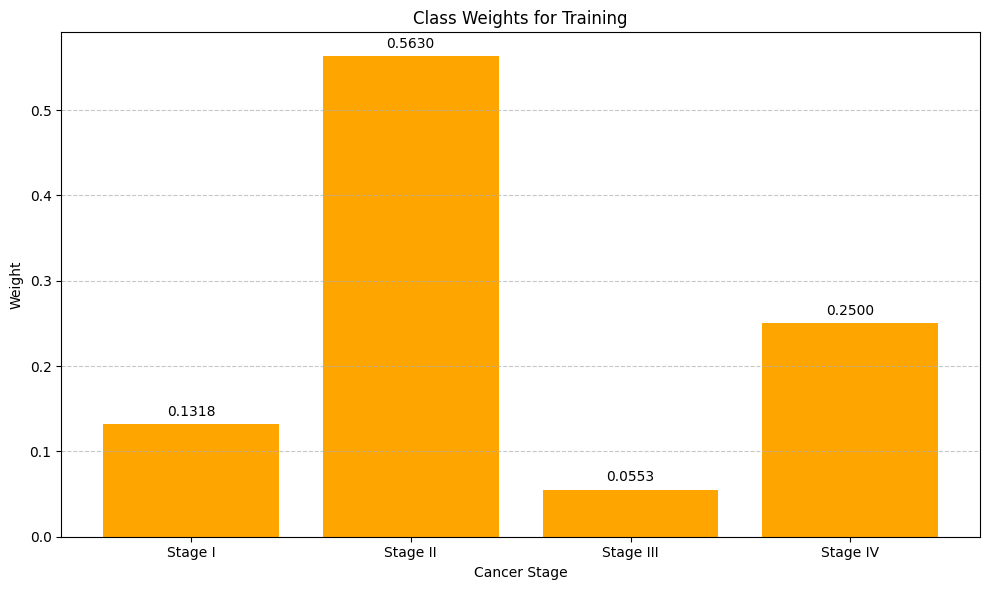


Class weights explanation:
- Higher weights are assigned to underrepresented classes
- During training, samples from classes with higher weights will contribute more to the loss
- This helps the model pay more attention to minority classes
- Combined with weighted sampling, this addresses class imbalance from two directions


In [39]:
# Visualize the class weights
if hasattr(train_dataset, 'class_weights'):
    class_names = ['Stage I', 'Stage II', 'Stage III', 'Stage IV']
    weights = train_dataset.class_weights.numpy()
    
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, weights, color='orange')
    plt.title('Class Weights for Training')
    plt.ylabel('Weight')
    plt.xlabel('Cancer Stage')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add weight values on top of bars
    for i, w in enumerate(weights):
        plt.text(i, w + 0.01, f'{w:.4f}', ha='center')
    
    plt.tight_layout()
    plt.show()
    
    print("\nClass weights explanation:")
    print("- Higher weights are assigned to underrepresented classes")
    print("- During training, samples from classes with higher weights will contribute more to the loss")
    print("- This helps the model pay more attention to minority classes")
    print("- Combined with weighted sampling, this addresses class imbalance from two directions")

In [32]:
# Create model
model = ResNet18_3D(num_classes=3)
model = model.to(device)

# Define loss function with class weights
criterion = nn.CrossEntropyLoss(weight=train_dataset.class_weights.to(device))
print(f"Using weighted loss function with weights: {train_dataset.class_weights}")

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Define learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

Using weighted loss function with weights: tensor([0.1318, 0.5630, 0.0553, 0.2500])


In [24]:
# Create checkpoint directory
checkpoint_dir = "checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    print(f"Created checkpoint directory: {checkpoint_dir}")

# Check if there's a checkpoint to resume from
resume_from = None
best_model_path = os.path.join(checkpoint_dir, "best_model.pth")
if os.path.exists(best_model_path):
    resume_from = best_model_path
    print(f"Found best model checkpoint: {resume_from}")

# Train model
print("Starting training...")
model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=num_epochs,
    patience=patience,
    checkpoint_dir=checkpoint_dir,
    save_freq=2,  # Save checkpoint every 5 epochs
    resume_from=resume_from
)

Found best model checkpoint: checkpoints\best_model.pth
Starting training...
Loading checkpoint from checkpoints\best_model.pth
Resuming from epoch 10 with best validation loss: 1.0182


Epoch 11/30 [Val]: 100%|██████████| 4/4 [03:47<00:00, 56.84s/it, loss=4.33, acc=0.04]   


Epoch 11/30 - Train Loss: 1.3093, Train Acc: 0.3235, Val Loss: 3.5740, Val Acc: 0.0400
No improvement for 1 epochs


Epoch 12/30 [Val]: 100%|██████████| 4/4 [03:51<00:00, 57.82s/it, loss=2.74, acc=0.04]   


Epoch 12/30 - Train Loss: 0.9416, Train Acc: 0.3706, Val Loss: 3.0443, Val Acc: 0.0400
Saved checkpoint to checkpoints\checkpoint_epoch_12.pth
No improvement for 2 epochs


Epoch 13/30 [Val]: 100%|██████████| 4/4 [04:20<00:00, 65.16s/it, loss=1.62, acc=0.04]   


Epoch 13/30 - Train Loss: 0.9348, Train Acc: 0.3529, Val Loss: 2.0779, Val Acc: 0.0400
No improvement for 3 epochs


Epoch 14/30 [Val]: 100%|██████████| 4/4 [03:46<00:00, 56.68s/it, loss=0.0445, acc=0.12]


Epoch 14/30 - Train Loss: 0.7696, Train Acc: 0.4176, Val Loss: 3.4716, Val Acc: 0.1200
Saved checkpoint to checkpoints\checkpoint_epoch_14.pth
No improvement for 4 epochs


Epoch 15/30 [Val]: 100%|██████████| 4/4 [03:52<00:00, 58.16s/it, loss=5.21, acc=0.04]   


Epoch 15/30 - Train Loss: 0.8042, Train Acc: 0.3588, Val Loss: 3.0968, Val Acc: 0.0400
No improvement for 5 epochs


Epoch 16/30 [Val]: 100%|██████████| 4/4 [03:25<00:00, 51.33s/it, loss=1.86, acc=0.04]   


Epoch 16/30 - Train Loss: 0.9473, Train Acc: 0.3176, Val Loss: 2.1956, Val Acc: 0.0400
Saved checkpoint to checkpoints\checkpoint_epoch_16.pth
No improvement for 6 epochs


Epoch 17/30 [Val]: 100%|██████████| 4/4 [03:37<00:00, 54.46s/it, loss=1.63, acc=0.04]   


Epoch 17/30 - Train Loss: 0.9665, Train Acc: 0.3118, Val Loss: 2.3884, Val Acc: 0.0400
No improvement for 7 epochs


Epoch 18/30 [Val]: 100%|██████████| 4/4 [03:38<00:00, 54.54s/it, loss=2.01, acc=0.04]   


Epoch 18/30 - Train Loss: 0.9038, Train Acc: 0.3118, Val Loss: 2.2523, Val Acc: 0.0400
Saved checkpoint to checkpoints\checkpoint_epoch_18.pth
No improvement for 8 epochs


Epoch 19/30 [Val]: 100%|██████████| 4/4 [03:45<00:00, 56.32s/it, loss=1.8, acc=0.04]    


Epoch 19/30 - Train Loss: 0.7793, Train Acc: 0.3353, Val Loss: 2.0373, Val Acc: 0.0400
No improvement for 9 epochs


Epoch 20/30 [Val]: 100%|██████████| 4/4 [03:44<00:00, 56.06s/it, loss=2.16, acc=0.04]  


Epoch 20/30 - Train Loss: 0.7483, Train Acc: 0.3941, Val Loss: 2.2840, Val Acc: 0.0400
Saved checkpoint to checkpoints\checkpoint_epoch_20.pth
No improvement for 10 epochs
Early stopping after 20 epochs
Saved final model to checkpoints\final_model.pth


In [25]:
# Save trained model
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to '{model_save_path}'")

Model saved to 'resnet18_3d_cancer_stage.pth'


## Evaluate the Model

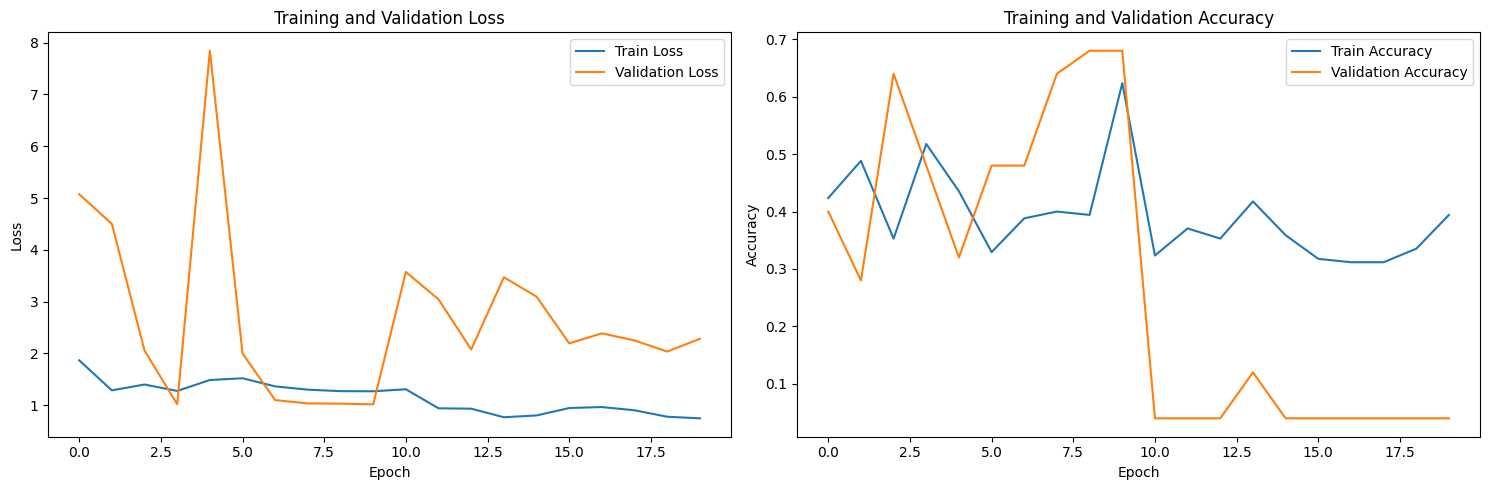

In [26]:
# Plot training history
plot_training_history(history)

In [27]:
# Evaluate model on test set
print("Evaluating model on test set...")
test_loss, test_acc, all_preds, all_labels = evaluate_model(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    device=device
)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Evaluating model on test set...


Evaluating: 100%|██████████| 7/7 [07:53<00:00, 67.69s/it] 

Test Loss: 2.0723, Test Accuracy: 0.0612


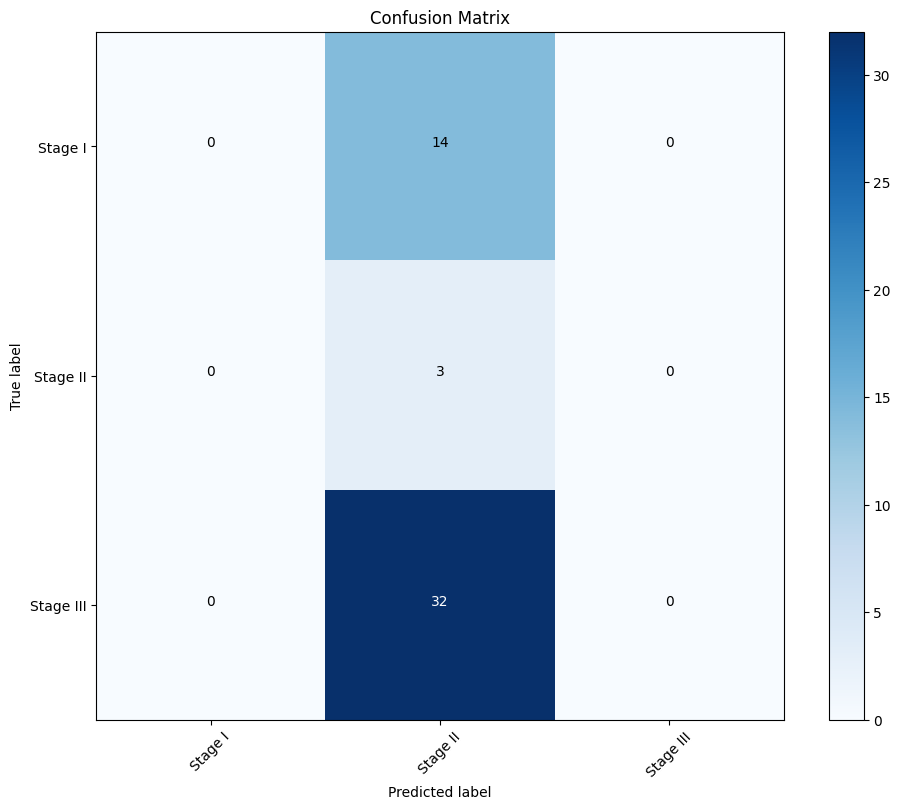

In [28]:
# Plot confusion matrix
class_names = ['Stage I', 'Stage II', 'Stage III', 'Stage IV']
# Use the updated plot_confusion_matrix function from train_3d_resnet.py
from train_3d_resnet import plot_confusion_matrix
plot_confusion_matrix(all_labels, all_preds, class_names)

In [29]:
# Print classification report
print("\nClassification Report:")
# Get unique classes present in the data
unique_classes = sorted(np.unique(all_labels))
# Create class names dynamically based on actual classes present
present_class_names = [class_names[i] for i in unique_classes]
print(classification_report(all_labels, all_preds, target_names=present_class_names))


Classification Report:
              precision    recall  f1-score   support

     Stage I       0.00      0.00      0.00        14
    Stage II       0.06      1.00      0.12         3
   Stage III       0.00      0.00      0.00        32

    accuracy                           0.06        49
   macro avg       0.02      0.33      0.04        49
weighted avg       0.00      0.06      0.01        49



## Load and Evaluate a Pretrained Model

In [17]:
def evaluate_pretrained_model(model_path, csv_path=csv_path, patch_size=patch_size, batch_size=batch_size,
                       base_dir=base_dir, target_spacing=target_spacing,
                       target_shape=target_shape, use_direct_processing=use_direct_processing, data_dir=None):
    """
    Load a pretrained model and evaluate it on the test set
    
    Args:
        model_path: Path to the pretrained model
        csv_path: Path to CSV with labels
        patch_size: Size of patches to extract
        batch_size: Batch size
        base_dir: Base directory containing patient data
        target_spacing: Target voxel spacing in mm
        target_shape: Target shape for preprocessing
        use_direct_processing: Whether to use direct processing without saving to disk
        data_dir: Directory with preprocessed data (only used if use_direct_processing=False)
    """
    print("=" * 80)
    print(f"EVALUATING PRETRAINED MODEL: {model_path}")
    print("=" * 80)
    
    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Create test dataset and dataloader
    if use_direct_processing:
        print("\nUsing direct processing without saving to disk...")
        test_dataset = DirectCTScanDataset(
            base_dir=base_dir,
            csv_path=csv_path,
            patch_size=patch_size,
            target_spacing=target_spacing,
            target_shape=target_shape,
            mode='test',
            use_augmentation=False
        )
    else:
        if data_dir is None:
            data_dir = "preprocessed_data_integrated"
        print(f"\nUsing preprocessed data from {data_dir}...")
        test_dataset = CTScanDataset(
            data_dir=data_dir,
            csv_path=csv_path,
            patch_size=patch_size,
            mode='test'
        )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    
    # Create model
    model = ResNet18_3D(num_classes=4)
    
    # Load pretrained weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    
    # Define loss function
    criterion = nn.CrossEntropyLoss()
    
    # Evaluate model on test set
    print("Evaluating model on test set...")
    test_loss, test_acc, all_preds, all_labels = evaluate_model(
        model=model,
        test_loader=test_loader,
        criterion=criterion,
        device=device
    )
    
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    
    # Plot confusion matrix
    class_names = ['Stage I', 'Stage II', 'Stage III', 'Stage IV']
    # Use the updated plot_confusion_matrix function from train_3d_resnet.py
    from train_3d_resnet import plot_confusion_matrix
    plot_confusion_matrix(all_labels, all_preds, class_names)
    
    # Print classification report
    print("\nClassification Report:")
    # Get unique classes present in the data
    unique_classes = sorted(np.unique(all_labels))
    # Create class names dynamically based on actual classes present
    present_class_names = [class_names[i] for i in unique_classes]
    print(classification_report(all_labels, all_preds, target_names=present_class_names))
    
    return test_acc

EVALUATING PRETRAINED MODEL: resnet18_3d_cancer_stage.pth
Using device: cpu

Using direct processing without saving to disk...
Unique values in Overall.Stage: ['IIIb' 'I' 'II' 'IIIa' nan]
Dropping 1 rows with NaN values in Overall.Stage
No CT scan directory found for patient LUNG1-001
No CT scan directory found for patient LUNG1-004
No study directory found for patient LUNG1-007
No study directory found for patient LUNG1-036
No study directory found for patient LUNG1-050
No CT scan directory found for patient LUNG1-051
No study directory found for patient LUNG1-058
No CT scan directory found for patient LUNG1-065
No study directory found for patient LUNG1-067
No CT scan directory found for patient LUNG1-077
No CT scan directory found for patient LUNG1-082
No CT scan directory found for patient LUNG1-083
No CT scan directory found for patient LUNG1-086
No CT scan directory found for patient LUNG1-093
No CT scan directory found for patient LUNG1-094
No CT scan directory found for patient

Evaluating: 100%|██████████| 7/7 [10:33<00:00, 90.46s/it] 


Test Loss: 0.9625, Test Accuracy: 0.5510


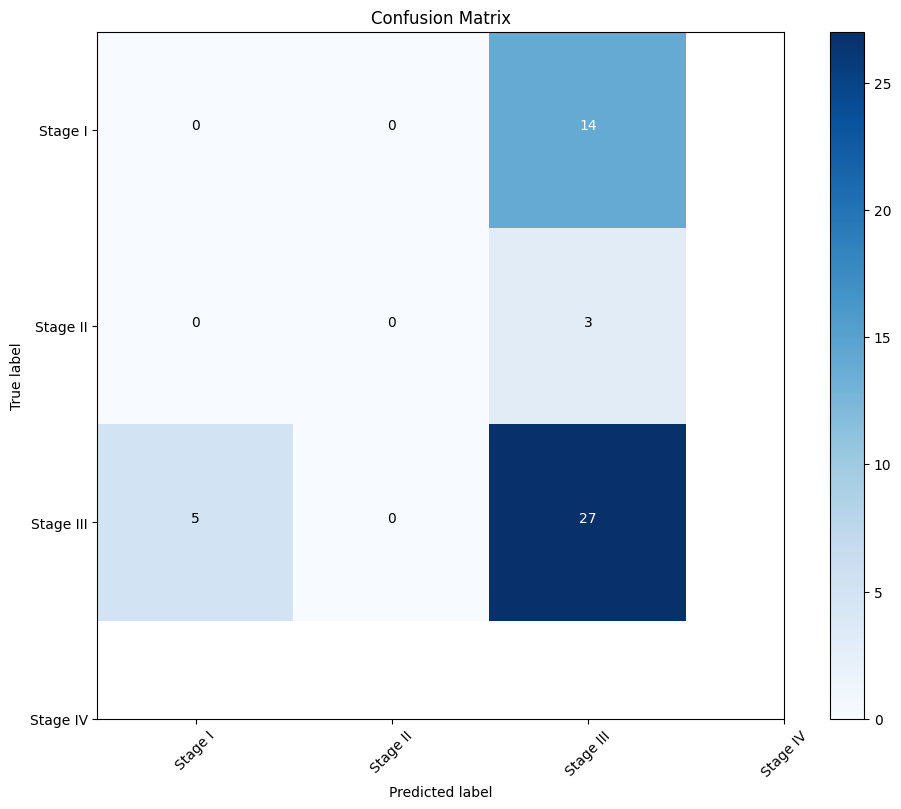


Classification Report:


ValueError: Number of classes, 3, does not match size of target_names, 4. Try specifying the labels parameter

In [18]:
evaluate_pretrained_model(model_path="resnet18_3d_cancer_stage.pth")